      Qiskit-Aer  Qiskit-Toaster    pyQuil-QVM  Cirq-Simulator
1       2.764106       20.581633     12.967438        0.720531
2       2.707124        4.111528     19.827694        1.003027
3       3.468484        6.420463     35.180300        1.312017
4       4.012227        8.860528     60.543060        1.829267
5       4.487395       13.077170     79.254448        2.613544
6       5.196273       17.370224    120.864004        3.187716
7       6.099820       23.028493    171.518475        4.034936
8       7.180214       29.276103    193.330765        5.097538
9       8.539885       40.988743    225.283593        6.065369
10     10.631233       49.409270    237.005651        7.337987
11     12.731642       60.330302    281.623363       10.077298
12     13.703585       88.383406    335.029066       10.896623
13     15.462160       81.791312    395.540655       12.983739
14     18.963009      103.751957    471.134901       16.177446
15    135.378212      135.076046    540.074289       22

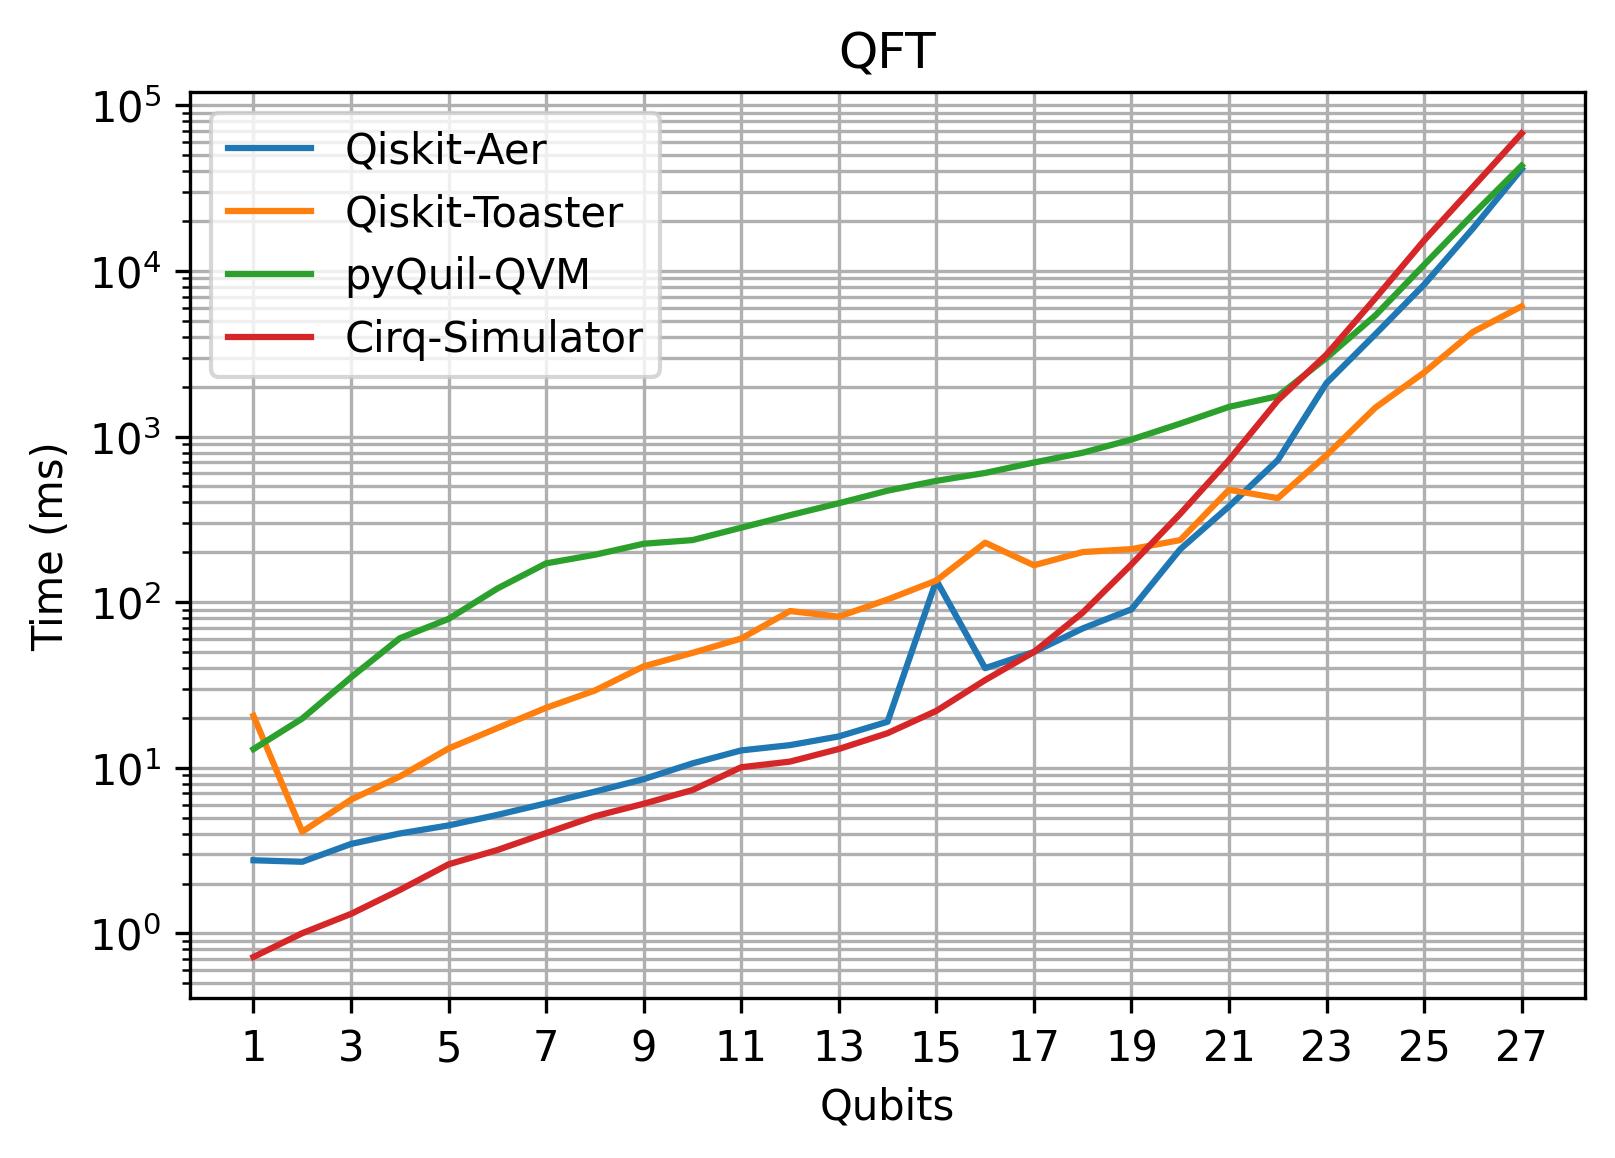

In [2]:
# Qiskit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer
from quantastica.qiskit_toaster import ToasterBackend

# pyQuil
from pyquil import Program, get_qc
from pyquil.gates import H, CPHASE, SWAP, MEASURE

# TFQ
import tensorflow_quantum as tfq
import cirq

# Common
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

%matplotlib inline


def qft_qiskit(n):
    qc = QuantumCircuit()

    q = QuantumRegister(n, 'q')
    c = ClassicalRegister(n, 'c')

    qc.add_register(q)
    qc.add_register(c)

    for j in range(n):
        for k in range(j):
            qc.cu1(math.pi/float(2**(j-k)), q[j], q[k])
        qc.h(q[j])

    for i in range(n):
        qc.measure(q[i], c[i])
        
    return qc


def qft_pyquil(n):
    p = Program()

    ro = p.declare('ro', memory_type='BIT', memory_size=n)

    for j in range(n):
        for k in range(j):
             p.inst(CPHASE(math.pi/float(2**(j-k)), j, k))
        p.inst(H(j))

    for i in range(n):
        p.inst(MEASURE(i, ro[i]))
        
    return p


def qft_cirq(n):
    q = cirq.GridQubit.rect(1, n)

    gates = []
    for j in range(n):
        for k in range(j):
             gates.append(cirq.ZPowGate(exponent=math.pi/float(2**(j-k))).controlled()(q[j], q[k]))
        gates.append(cirq.H(q[j]))

    for i in range(n):
        gates.append(cirq.measure(q[i], key='c' + str(i)))
    
    circ = cirq.Circuit(gates)

    return circ


def benchmark_qft_qiskit(from_qubits, to_qubits, results):
    results["Qiskit-Aer"] = np.nan
    results["Qiskit-Toaster"] = np.nan

    aer_backend = Aer.get_backend('qasm_simulator')
    toaster_backend = ToasterBackend.get_backend('qasm_simulator')

    for i in range(from_qubits, to_qubits + 1):

        circ = qft_qiskit(i)

        # Repeat multiple times for small number of qubits and get average time
        repeat = 4 if i <= 20 else 1

        # Qiskit with Aer backend
        aer_time = np.nan
        for r in range(repeat):
            start_time = time.time()
            job = execute(circ, backend=aer_backend, shots=1)
            result = job.result()
            elapsed_time = (time.time() - start_time) * 1000
            aer_time = elapsed_time if np.isnan(aer_time) else ((aer_time + elapsed_time) / 2)
        results["Qiskit-Aer"][i] = aer_time

        # Qiskit with Toaster backend
        toaster_time = np.nan
        for r in range(repeat):
            start_time = time.time()
            job = execute(circ, backend=toaster_backend, shots=1)
            result = job.result()
            elapsed_time = (time.time() - start_time) * 1000
            toaster_time = elapsed_time if np.isnan(toaster_time) else ((toaster_time + elapsed_time) / 2)
        results["Qiskit-Toaster"][i] = toaster_time


def benchmark_qft_pyquil(from_qubits, to_qubits, results):
    results["pyQuil-QVM"] = np.nan

    for i in range(from_qubits, to_qubits + 1):

        circ = qft_pyquil(i)
        circ.wrap_in_numshots_loop(1)

        # Repeat multiple times for small number of qubits and get average time
        repeat = 4 if i <= 20 else 1

        # pyQuil with QVM backend
        qc = get_qc(str(i) + 'q-qvm')
        
        qvm_time = np.nan
        for r in range(repeat):
            start_time = time.time()
            result = qc.run(circ)        
            elapsed_time = (time.time() - start_time) * 1000
            qvm_time = elapsed_time if np.isnan(qvm_time) else ((qvm_time + elapsed_time) / 2)
        results["pyQuil-QVM"][i] = qvm_time

        
def benchmark_qft_cirq(from_qubits, to_qubits, results):
    results["Cirq-Simulator"] = np.nan
    #results["TFQ"] = np.nan

    for i in range(from_qubits, to_qubits + 1):
        simulator = cirq.Simulator()

        circ = qft_cirq(i)

        # Repeat multiple times for small number of qubits and get average time
        repeat = 4 if i <= 20 else 1

        # Cirq simulator
        cirq_time = np.nan
        for r in range(repeat):
            start_time = time.time()
            result = simulator.run(circ, repetitions=1)
            elapsed_time = (time.time() - start_time) * 1000
            cirq_time = elapsed_time if np.isnan(cirq_time) else ((cirq_time + elapsed_time) / 2)
        results["Cirq-Simulator"][i] = cirq_time

        """
        # TFQ simulator
        tfq_time = np.nan
        for r in range(repeat):
            start_time = time.time()
            result = tfq.layers.Sample()(circ, repetitions=1)
            elapsed_time = (time.time() - start_time) * 1000
            tfq_time = elapsed_time if np.isnan(tfq_time) else ((tfq_time + elapsed_time) / 2)
        results["TFQ"][i] = tfq_time
        """


def benchmark_qft(from_qubits, to_qubits):
    results = pd.DataFrame(index=range(from_qubits, to_qubits + 1), columns=[])
    
    # Qiskit
    benchmark_qft_qiskit(from_qubits, to_qubits, results)
    
    # pyQuil
    benchmark_qft_pyquil(from_qubits, to_qubits, results)

    # Cirq
    benchmark_qft_cirq(from_qubits, to_qubits, results)

    print(results)

    plt.figure(dpi=300)
    plt.title("QFT")
    plt.xlabel("Qubits")
    plt.ylabel("Time (ms)")
    plt.xticks(range(from_qubits, to_qubits + 1, 2))
    plt.yscale("log")
    plt.plot(results)
    plt.grid(which='both')
    plt.legend(loc="upper left", labels=results.columns)
    plt.savefig("benchmark_qft.png")


benchmark_qft(1, 27)
